# Mail Classification Model

## Importing Libraries

In [1]:
import os
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, CuDNNLSTM
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

### Load Dataset from Files

In [2]:
# The dataset is in the folder DATA_FOLDER
DATA_FOLDER = 'new_data'
texts = []
labels = []
folders = ['ham', 'spam', 'social', 'promotion']
for folder in folders:
    path = f'{DATA_FOLDER}/{folder}'
    files = os.listdir(path)
    print('#Files: ', len(files))
    
    labels += [folder]*len(files)
    
    for file in tqdm(files):
        text = open(f'{path}/{file}', encoding='utf-8').read()
        texts.append(text)

FileNotFoundError: [Errno 2] No such file or directory: 'new_data/ham'

In [ ]:
df = pd.DataFrame(data=[texts, labels]).T
df.columns = ['text', 'labels']

### Save Dataset

In [ ]:
pickling_on = open("../models/dataset.pkl","wb")
pickle.dump(df,pickling_on)
pickling_on.close()

### Load Saved Dataset

In [3]:
pickling_on = open("../models/dataset.pkl","rb")
df = pickle.load(pickling_on)
pickling_on.close()

### TFIDF Vectorizer Fit and Transform

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=200)
x = vectorizer.fit_transform(df['text'])

### Save Vectorizer

In [62]:
pickling_on = open("../models/vectorizer.pkl","wb")
pickle.dump(vectorizer, pickling_on)
pickling_on.close()

### Load Vectorizer

In [4]:
pickling_on = open("../models/vectorizer.pkl","rb")
vectorizer = pickle.load(pickling_on)
pickling_on.close()

/home/kaush/.local/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.21.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/kaush/.local/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.21.1 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [5]:
x = vectorizer.transform(df['text'])

### Train Test Split of Dataset

In [6]:
X_train, X_test, y_train, y_test = train_test_split(x, df.labels, test_size=0.10, random_state=42, shuffle = True, stratify=df.labels)

# SVM MODEL

## Create Model and Train

In [ ]:
model = LinearSVC(C=10, class_weight='balanced', dual=True, fit_intercept=True,
                intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                multi_class='ovr', penalty='l2', random_state=0, tol=1e-05, verbose=True)

model.fit(X_train, y_train)

### Saving SVM Model

In [ ]:
pickling_on = open("../models/model.pkl","wb")
pickle.dump(model,pickling_on)
pickling_on.close()

### Loading Saved Model

In [7]:
pickling_on = open("../models/model.pkl","rb")
model = pickle.load(pickling_on)
pickling_on.close()

### Test Data Prediction

In [8]:
y_pred = model.predict(X_test)

## Model's Accuracy Score

In [9]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy : {0:.2f} %".format(accuracy*100))

Accuracy : 94.12 %


## Model's Confusion Matrix

In [10]:
print(confusion_matrix(y_test, y_pred))

[[1518    1    1  135]
 [   0  165    0    2]
 [   1    1  131    1]
 [  73    0    1 1642]]


## Model's Classification Report

In [11]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         ham       0.95      0.92      0.94      1655
   promotion       0.99      0.99      0.99       167
      social       0.98      0.98      0.98       134
        spam       0.92      0.96      0.94      1716

    accuracy                           0.94      3672
   macro avg       0.96      0.96      0.96      3672
weighted avg       0.94      0.94      0.94      3672



# LSTM MODEL

## Build the model

In [12]:
clear_session()
model = Sequential()
model.add(LSTM(32, input_shape=(200, 1), name='LSTM'))
model.add(Dense(4, activation='softmax', name='Classifier'))
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 32)                4352      
_________________________________________________________________
Classifier (Dense)           (None, 4)                 132       
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
_________________________________________________________________
None


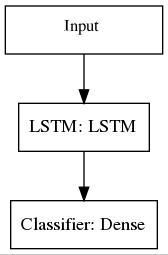

In [13]:
from IPython.display import Image
Image(filename='model.png') 

## If the model has been trained already, load the model
### Run this only after the model has been trained and saved

In [12]:
model = load_model('../models/model.h5')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 4)                 132       
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
plot_model(model)

## We can use the same X_train and X_test data for the LSTM model. By using the same input data, we can compare the models quite well.

**But, we need to encode the Labels. **

In [15]:
encoder = LabelEncoder()
y_train_lstm = encoder.fit_transform(y_train)
y_test_lstm = encoder.fit_transform(y_test)

## Save the encoder

In [16]:
pickle.dump(encoder, open('../models/encoder.pkl', 'wb'))

## Load the encoder

In [20]:
encoder = pickle.load(open('../models/encoder.pkl', 'rb'))

## For LSTM, we need to reshape the data

In [17]:
X_train_lstm = X_train.toarray().reshape(-1, 200, 1)
X_test_lstm = X_test.toarray().reshape(-1, 200, 1)
print(X_train_lstm.shape, X_test_lstm.shape)

(33044, 200, 1) (3672, 200, 1)


## Callbacks for saving the model and stopping training if validation accuracy does not improve

In [18]:
callbacks = [
    EarlyStopping(patience=10),
    ModelCheckpoint('../models/model.h5', period=5)
]

## Compile the model and fit the model on the data

In [19]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_lstm, y_train_lstm, batch_size=512, epochs=250, validation_split=0.1, callbacks=callbacks)

Train on 29739 samples, validate on 3305 samples
Epoch 1/250
29739/29739 [==============================] - 15s 510us/sample - loss: 1.1456 - acc: 0.4683 - val_loss: 0.9745 - val_acc: 0.4708
Epoch 2/250
29739/29739 [==============================] - 14s 478us/sample - loss: 0.9772 - acc: 0.4655 - val_loss: 0.9707 - val_acc: 0.4708
Epoch 3/250
29739/29739 [==============================] - 14s 461us/sample - loss: 0.9766 - acc: 0.4718 - val_loss: 0.9702 - val_acc: 0.4708
Epoch 4/250
29739/29739 [==============================] - 14s 472us/sample - loss: 0.9757 - acc: 0.4717 - val_loss: 0.9692 - val_acc: 0.4708
Epoch 5/250
29739/29739 [==============================] - 14s 473us/sample - loss: 0.9751 - acc: 0.4669 - val_loss: 0.9685 - val_acc: 0.4708
Epoch 6/250
29739/29739 [==============================] - 14s 465us/sample - loss: 0.9742 - acc: 0.4645 - val_loss: 0.9665 - val_acc: 0.4705
Epoch 7/250
29739/29739 [==============================] - 14s 468us/sample - loss: 0.9698 - acc: 0

29739/29739 [==============================] - 14s 460us/sample - loss: 0.5123 - acc: 0.7902 - val_loss: 0.5447 - val_acc: 0.7691
Epoch 59/250
29739/29739 [==============================] - 14s 467us/sample - loss: 0.5082 - acc: 0.7925 - val_loss: 0.6024 - val_acc: 0.7480
Epoch 60/250
29739/29739 [==============================] - 14s 461us/sample - loss: 0.5275 - acc: 0.7826 - val_loss: 0.5655 - val_acc: 0.7540
Epoch 61/250
29739/29739 [==============================] - 14s 466us/sample - loss: 0.5124 - acc: 0.7888 - val_loss: 0.6003 - val_acc: 0.7470
Epoch 62/250
29739/29739 [==============================] - 14s 461us/sample - loss: 0.5271 - acc: 0.7821 - val_loss: 0.5214 - val_acc: 0.7864
Epoch 63/250
29739/29739 [==============================] - 14s 467us/sample - loss: 0.5063 - acc: 0.7929 - val_loss: 0.5109 - val_acc: 0.7873
Epoch 64/250
29739/29739 [==============================] - 14s 470us/sample - loss: 0.5219 - acc: 0.7846 - val_loss: 0.5709 - val_acc: 0.7631
Epoch 65/250

In [20]:
pickle.dump(model.history.history, open('../models/history.pkl', 'wb'))

In [21]:
train_loss = model.history.history['loss']
train_acc = model.history.history['acc']
val_loss = model.history.history['val_loss']
val_acc = model.history.history['val_acc']

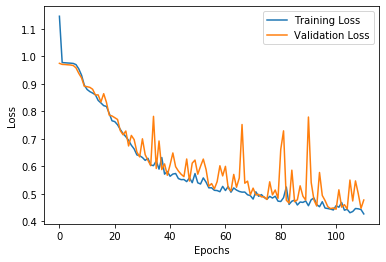

In [25]:
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.show()

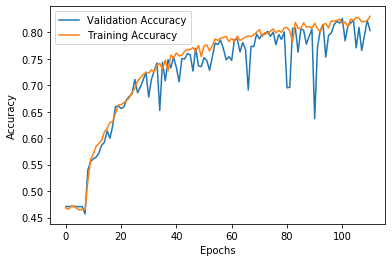

In [23]:
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc, label='Training Accuracy')
plt.legend()
plt.show()

## Predict the labels

In [26]:
preds = model.predict_classes(X_test_lstm)

## Confusion Matrix

In [27]:
print(confusion_matrix(y_test_lstm, preds))

[[1109   11   13  522]
 [  10  130   15   12]
 [  11    5  100   18]
 [  89   12   11 1604]]


## Accuracy

In [28]:
accuracy = accuracy_score(y_test_lstm, preds)
print("Accuracy : {0:.2f} %".format(accuracy*100))

Accuracy : 80.15 %


## Classification Report

In [29]:
print(classification_report(y_test_lstm, preds))

              precision    recall  f1-score   support

           0       0.91      0.67      0.77      1655
           1       0.82      0.78      0.80       167
           2       0.72      0.75      0.73       134
           3       0.74      0.93      0.83      1716

    accuracy                           0.80      3672
   macro avg       0.80      0.78      0.78      3672
weighted avg       0.82      0.80      0.80      3672



# Receiver Operating Characteristic of Classifier

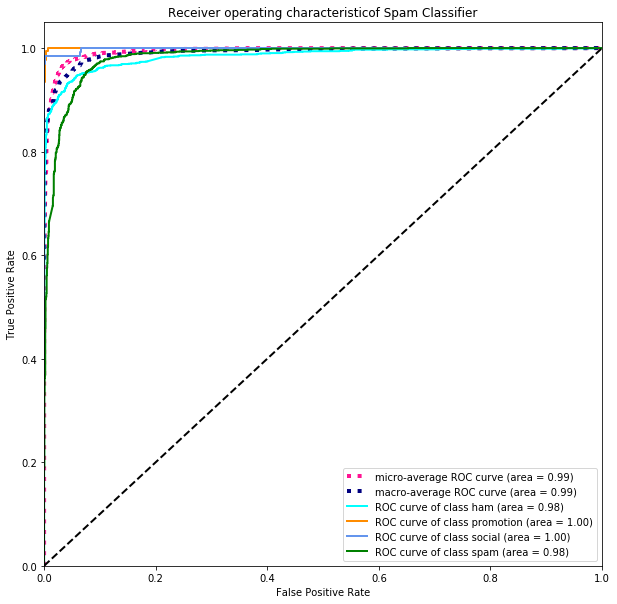

In [10]:
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

## Compute ROC curve and ROC area for each class
y_test = label_binarize(y_test, classes=['ham', 'promotion', 'social', 'spam'])
y_score = model.decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

classes=['ham', 'promotion', 'social', 'spam']
n_classes = 4

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
lw=2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristicof Spam Classifier')
plt.legend(loc="lower right")
plt.show()